## [1. Imports](#im) ##
## [2. HyperParameters](#hp) ##
## [3. Data Loading and Preprocessing](#data) ##
## [4. DenseNet169 Model](#model)  ##
## [5. Training and Fine Tuning](#train) ##
## [6. Visualizing Results](#vis) ##

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center>

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [39]:
train_dir = "/content/drive/MyDrive/CNN/train"
test_dir = "/content/drive/MyDrive/CNN/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30
FINE_TUNING_EPOCHS = 20
LR = 0.01
NUM_CLASSES = 3
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Angry', 'Happy','Sad']
CLASS_LABELS_EMOJIS = ["👿","😊", "😔" ]

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [40]:
preprocess_fun = tf.keras.applications.regnet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True ,
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 1823 images belonging to 3 classes.
Found 455 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


## Images with different emotions

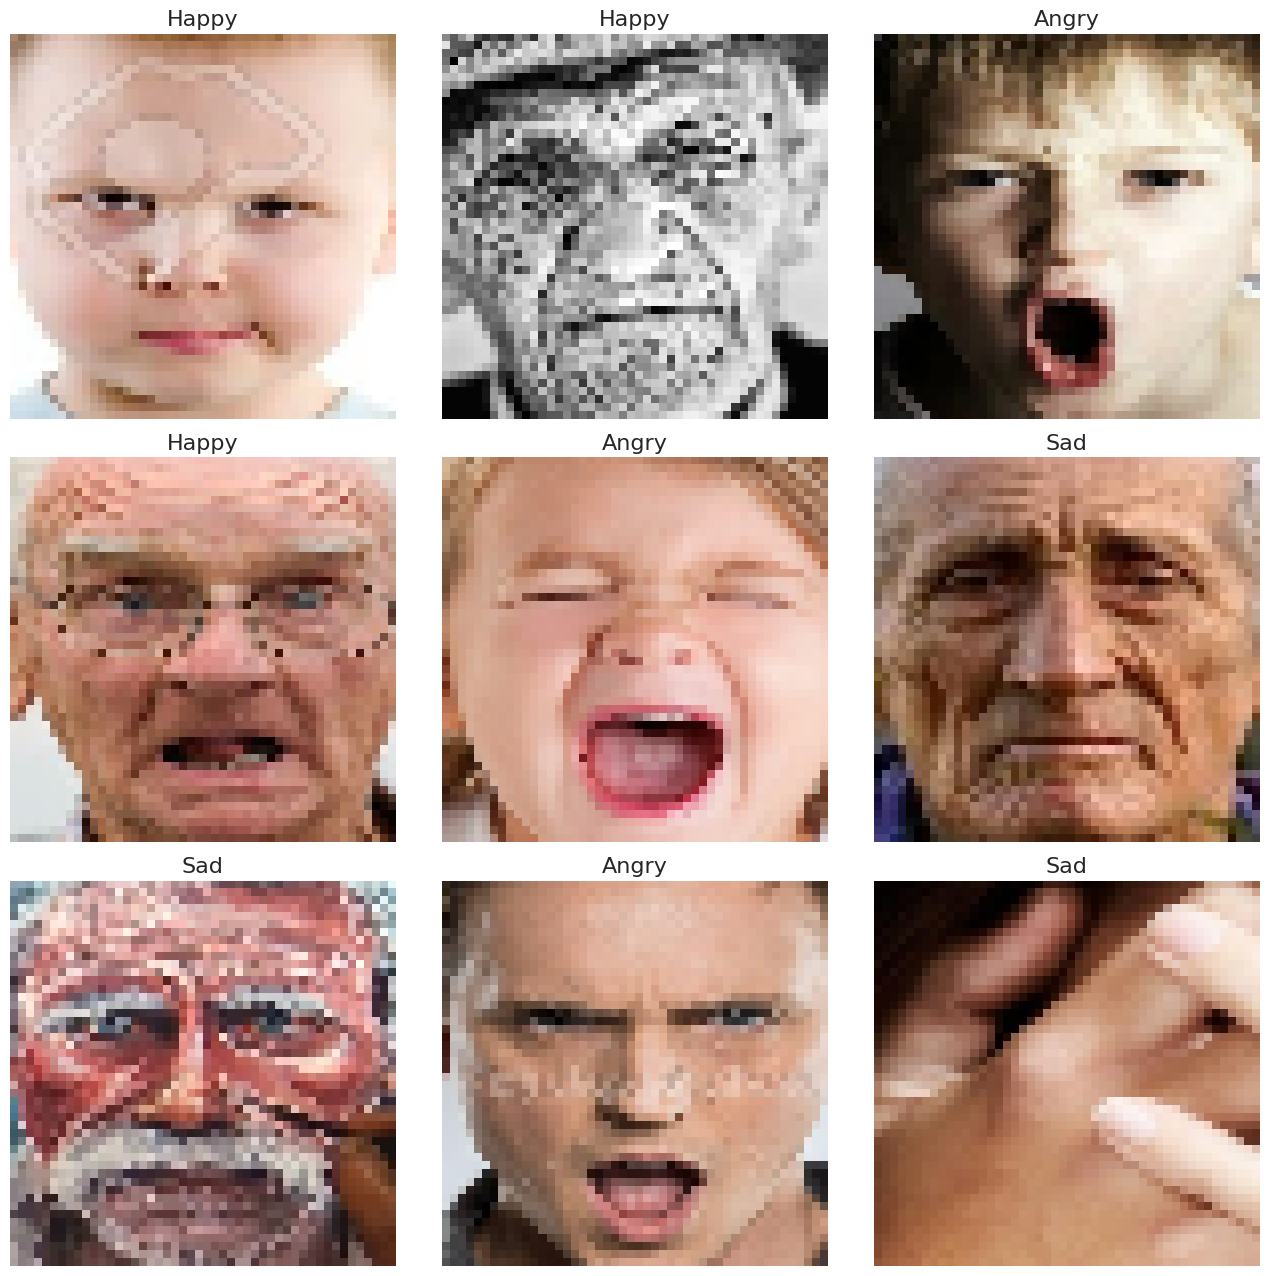

In [41]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)

def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True ,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1)
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

## Data distribution (count) among differnt emotions

In [42]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] ,
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld")
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id="model"></a>
# <center> Regnet Transfer Learning  </center>

In [43]:
from tensorflow.keras.applications import regnet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.RegNetY320(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)

    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)

    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)

    return classification_output

def define_compile_model():

    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    model.compile(optimizer=tf.keras.optimizers.SGD(0.1),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

    return model

In [44]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# def feature_extractor(inputs):
#     # Use ResNet50 as the feature extractor
#     resnet_feature_extractor = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#                                         include_top=False,
#                                         weights='imagenet')(inputs)

#     return resnet_feature_extractor

# def classifier(inputs):
#     x = GlobalAveragePooling2D()(inputs)
#     x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     x = Dropout(0.3)(x)
#     x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     x = Dropout(0.5)(x)
#     x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
#     x = Dropout(0.5)(x)
#     x = Dense(3, activation="softmax", name="classification")(x)

#     return x

# def final_model(inputs):
#     resnet_feature_extractor = feature_extractor(inputs)
#     classification_output = classifier(resnet_feature_extractor)

#     return classification_output

# def define_compile_model():
#     inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
#     classification_output = final_model(inputs)
#     model = tf.keras.Model(inputs=inputs, outputs=classification_output)

#     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model

## Summary of model

In [45]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 regnety320 (Functional)     (None, 2, 2, 3712)        141492058 
                                                                 
 global_average_pooling2d_2  (None, 3712)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               950528    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1024)              263168    
                                                           

<a id="train"></a>
# <center> Training and Fine-Tuning </center>

## Training model with freezed layers of Regnet


In [46]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS,
                    validation_data = validation_generator,
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/30
29/29 [==============================] - 78s 1s/step - loss: 15.9813 - accuracy: 0.3670 - val_loss: 15.0814 - val_accuracy: 0.4176
Epoch 2/30
29/29 [==============================] - 11s 384ms/step - loss: 14.3326 - accuracy: 0.4054 - val_loss: 13.5181 - val_accuracy: 0.4527
Epoch 3/30
29/29 [==============================] - 11s 368ms/step - loss: 12.8479 - accuracy: 0.4163 - val_loss: 12.1641 - val_accuracy: 0.4901
Epoch 4/30
29/29 [==============================] - 12s 393ms/step - loss: 11.5554 - accuracy: 0.4251 - val_loss: 10.9315 - val_accuracy: 0.4879
Epoch 5/30
29/29 [==============================] - 11s 378ms/step - loss: 10.4131 - accuracy: 0.4229 - val_loss: 9.8344 - val_accuracy: 0.5055
Epoch 6/30
29/29 [==============================] - 11s 364ms/step - loss: 9.3755 - accuracy: 0.4405 - val_loss: 8.8579 - val_accuracy: 0.5055
Epoch 7/30
29/29 [==============================] - 11s 385ms/step - loss: 8.4594 - accuracy: 0.4613 - val_loss: 8.0013 - val_accuracy: 

## Fine Tuning

In [47]:
# Un-Freezing the feature extraction layers for fine tuning
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = FINE_TUNING_EPOCHS ,validation_data = validation_generator)
history = history.append(pd.DataFrame(history_.history) , ignore_index=True)

Epoch 1/20
29/29 [==============================] - 37s 438ms/step - loss: 1.1425 - accuracy: 0.7411 - val_loss: 1.3465 - val_accuracy: 0.6374
Epoch 2/20
29/29 [==============================] - 11s 370ms/step - loss: 1.1539 - accuracy: 0.7318 - val_loss: 1.3533 - val_accuracy: 0.6286
Epoch 3/20
29/29 [==============================] - 11s 371ms/step - loss: 1.1512 - accuracy: 0.7389 - val_loss: 1.3482 - val_accuracy: 0.6374
Epoch 4/20
29/29 [==============================] - 11s 361ms/step - loss: 1.1683 - accuracy: 0.7170 - val_loss: 1.3447 - val_accuracy: 0.6396
Epoch 5/20
29/29 [==============================] - 11s 378ms/step - loss: 1.1560 - accuracy: 0.7345 - val_loss: 1.3518 - val_accuracy: 0.6330
Epoch 6/20
29/29 [==============================] - 11s 368ms/step - loss: 1.1370 - accuracy: 0.7482 - val_loss: 1.3488 - val_accuracy: 0.6330
Epoch 7/20
29/29 [==============================] - 11s 364ms/step - loss: 1.1326 - accuracy: 0.7488 - val_loss: 1.3475 - val_accuracy: 0.6418

## Training plots

In [48]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [49]:
x = px.line(data_frame= history ,
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

<a id="vis"></a>
# <center> Visualizing Results </center>

## Model Evaluation

In [50]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

9/9 [==============================] - 3s 139ms/step


## Confusion Matrix

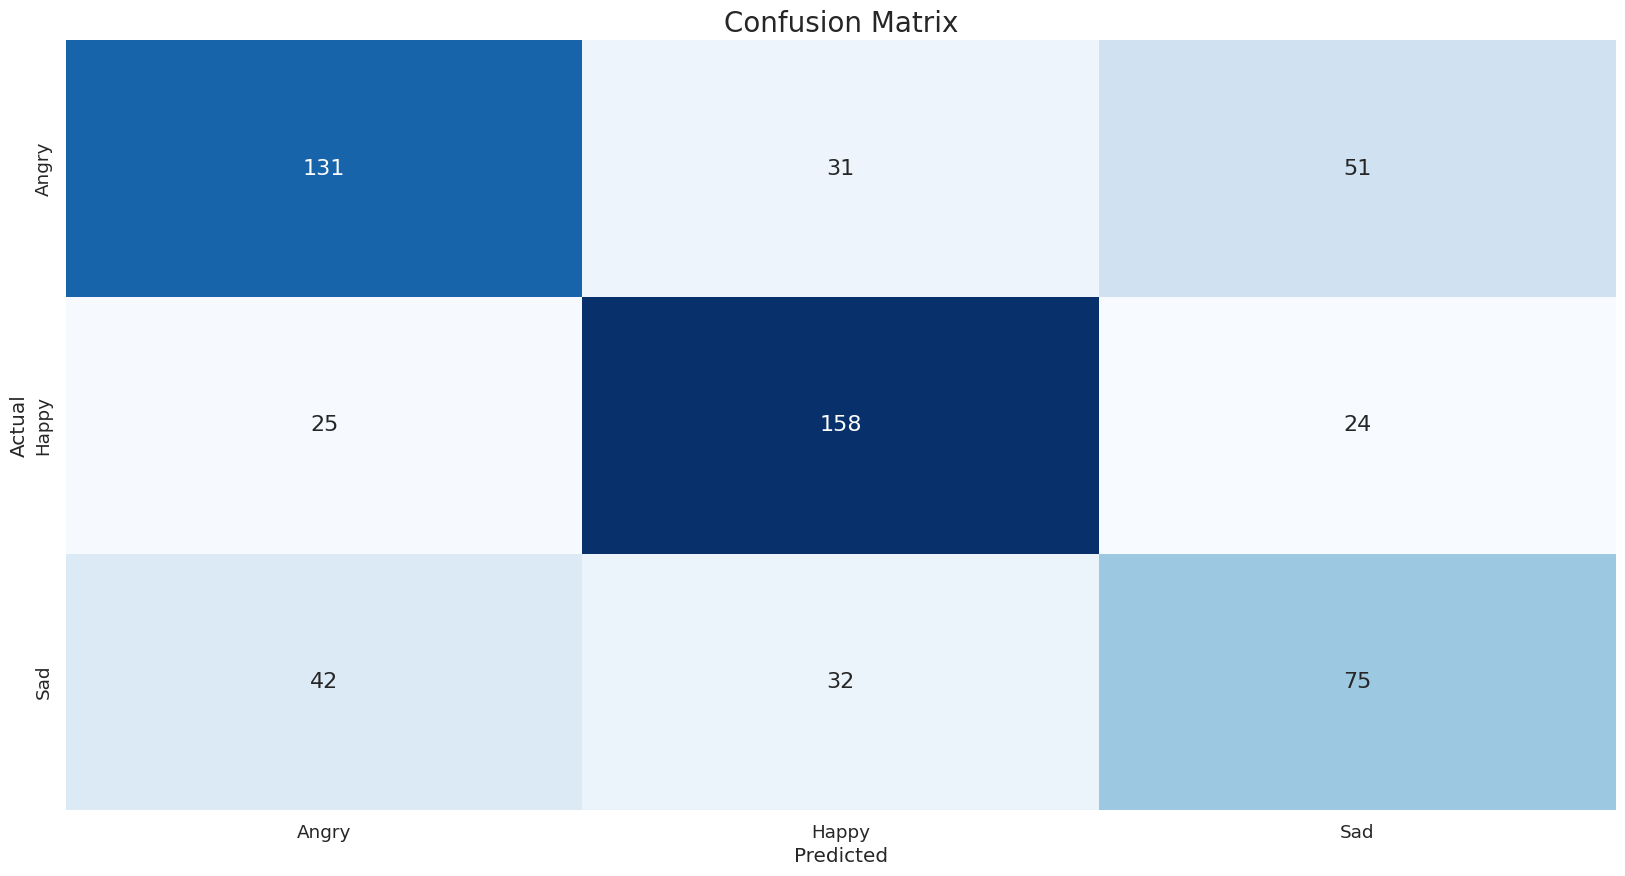

In [51]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report

In [52]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       213
           1       0.71      0.76      0.74       207
           2       0.50      0.50      0.50       149

    accuracy                           0.64       569
   macro avg       0.63      0.63      0.63       569
weighted avg       0.64      0.64      0.64       569



## Multiclass AUC Curve

ROC AUC score: 0.8125785687590538


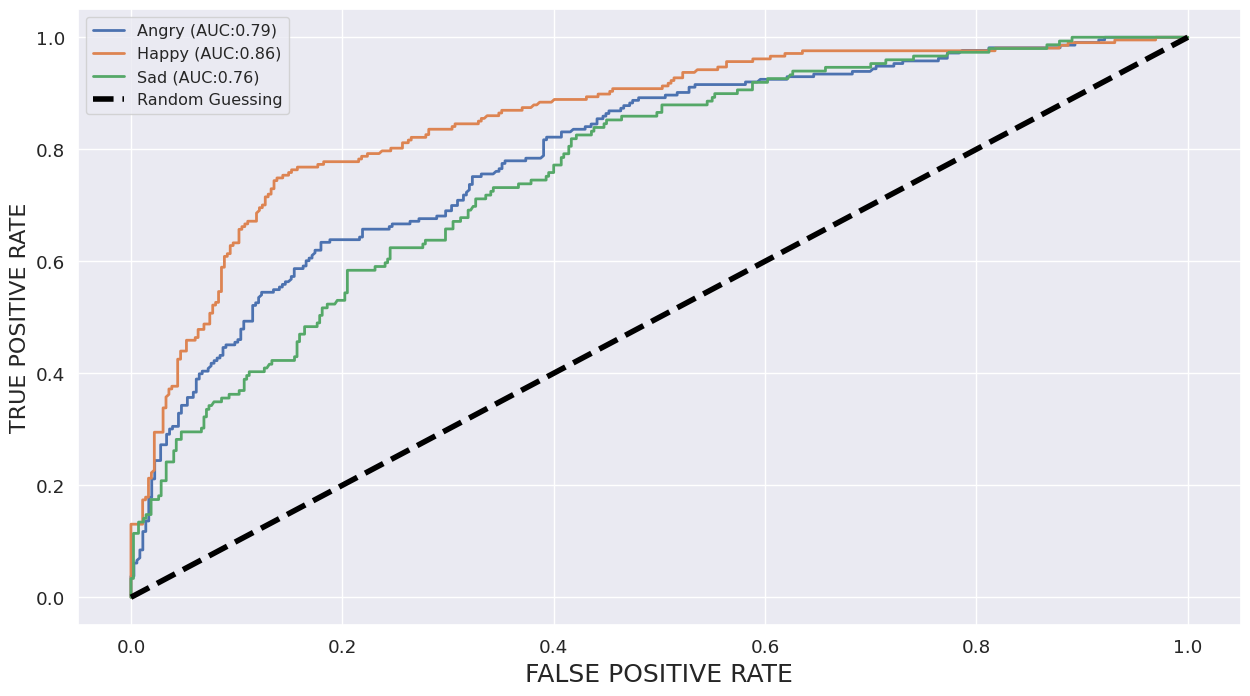

In [53]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [54]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8055231683087151
